<a href="https://colab.research.google.com/github/mrozgurer/Plant-Seedling-An-Image-Recognition-Project/blob/main/8_PlantsSeedlingProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os # It provides an easy way for the user to interact with several os functions that come in handy in day to day programming.
import numpy as np                                                                               
import pandas as pd                                                                              
import matplotlib.pyplot as plt                                                                  
import math  # This is for performing mathematical operations                                                                                 
import cv2   # This allows us to use OpenCV for image processing                                                                                       
import seaborn as sns                                                                            


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # This allows us to generate data for data augmentation process                            
from tensorflow.keras.models import Sequential                                                   
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation, LeakyReLU
from tensorflow.keras.optimizers import Adam # These will be used to create a CNN model
from tensorflow.keras.optimizers import Adam,SGD                                                 
from sklearn import preprocessing
from sklearn.preprocessing import LabelBinarizer # This is used to encode target variables                                                               
from sklearn.model_selection import train_test_split                                             
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix                                                    


from google.colab.patches import cv2_imshow   # Display images using OpenCV                                                   

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from tensorflow.keras import optimizers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Loading and Summarizing the Dataset#

In [ ]:
# We are going to import both the images and labels corresponding to them separately

images = np.load('/content/drive/MyDrive/images.npy')

labels = pd.read_csv('/content/drive/MyDrive/Labels.csv')

In [ ]:
# We will load the dataset and print the overview of the data

print(images.shape)

print(labels.shape)

(4750, 128, 128, 3)
(4750, 1)


This means that there are 4750 RGB images of shape 128 x 128 X 3 and each image has 3 channels (i.e. Red, Green, Blue).

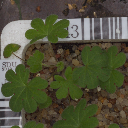

In [ ]:
# Now, we will plot the images using both OpenCV and matplotlib to see if there is a difference between them in terms of display

cv2_imshow(images[3])

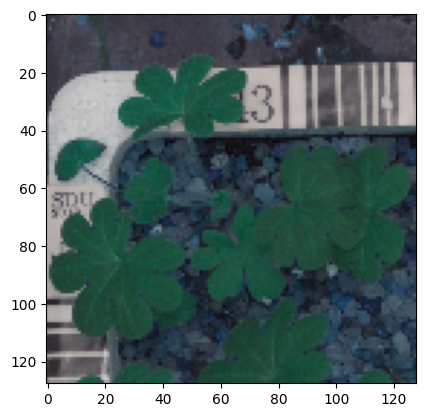

In [ ]:
plt.imshow(images[3])

We see that there is a difference of color between the images created by OpenCV and those created by matplotlib. It is due to that OpenCV uses BGR (Blue-Green-Red) format, whereas matplotlib uses the original RGB (Red-Green-Blue) format. However, interpreting BGR format is a bit difficult and tricky, so we need to convert the BGR format to RGB, so interpreting numpy arrays and the analysis result will be easier. 

In [ ]:
for i in range(len(images)):
  images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

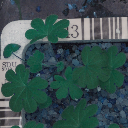

In [ ]:
cv2_imshow(images[3])

As we see, the images in the image file have been converted to RGB format.

##Plotting the images from each class and printing their corresponding labels##

In [ ]:
def plot_images(images,labels):
  num_classes=12                                                               
  categories=np.unique(labels)   
  keys=dict(labels['Label'])                                                      
  rows = 3                                                                       
  cols = 4                                                                   
  fig = plt.figure(figsize=(10, 8))                                              
  for i in range(cols):
      for j in range(rows):
          random_index = np.random.randint(0, len(labels))
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)
          ax.imshow(images[random_index, :])                                 
          ax.set_title(keys[random_index])
  plt.show()

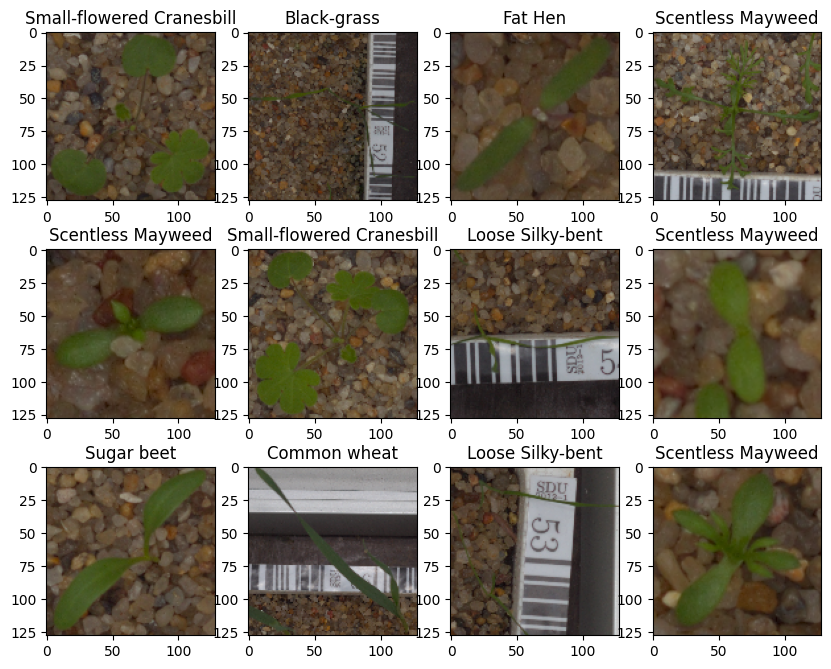

In [ ]:
plot_images(images,labels)

In [ ]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4750 entries, 0 to 4749
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   4750 non-null   object
dtypes: object(1)
memory usage: 37.2+ KB


In [ ]:
labels.nunique()

Label    12
dtype: int64

In [ ]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4750 entries, 0 to 4749
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   4750 non-null   object
dtypes: object(1)
memory usage: 37.2+ KB


#Exploratory Data Analysis#

In [ ]:
# The code below will show us the name of the each class in labels and their count

labels_cat=['Label']
for column in labels_cat:
  print(labels[column].value_counts())
  print('-'*50) # This returns fifty dashes separating each variable in the code above

Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Common wheat                 221
Maize                        221
Name: Label, dtype: int64
--------------------------------------------------


In [ ]:
# We will create a variable that includes the list of species

labels_classes=['Loose Silky-bent','Common Chickweed','Scentless Mayweed','Small-flowered Cranesbill','Fat Hen','Charlock','Sugar beet','Cleavers','Black-grass','Shepherds Purse','Common wheat','Maize']

##Countplot##

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'Small-flowered Cranesbill'),
  Text(1, 0, 'Fat Hen'),
  Text(2, 0, 'Shepherds Purse'),
  Text(3, 0, 'Common wheat'),
  Text(4, 0, 'Common Chickweed'),
  Text(5, 0, 'Charlock'),
  Text(6, 0, 'Cleavers'),
  Text(7, 0, 'Scentless Mayweed'),
  Text(8, 0, 'Sugar beet'),
  Text(9, 0, 'Maize'),
  Text(10, 0, 'Black-grass'),
  Text(11, 0, 'Loose Silky-bent')])

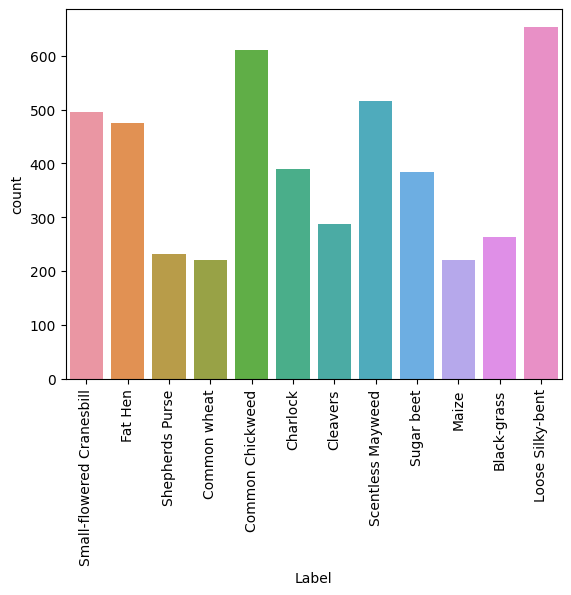

In [ ]:
# The code will create the countplot, so we can see if there is imbalance

sns.countplot(data=labels, x='Label')
plt.xticks(rotation='vertical')


The countplot shows that there is imbalance between classes in terms frequency. For example, there are more than 600 images of Loose Silky-bent, whereas there are only 200 images of Common wheat, which is huge imbalance. Therefore, after splitting the data into train and test, we should adress this issue by boosting the weight of the classes with fewer counts on target's train set.

##Resizing the image##

We can also try to resize the image. The current image size is 128x128, meaning that width and height of each image is represented by 128 pixels, which can be computationally time- and power-consuming. We can make it 64x64, so it will spend less computational power.

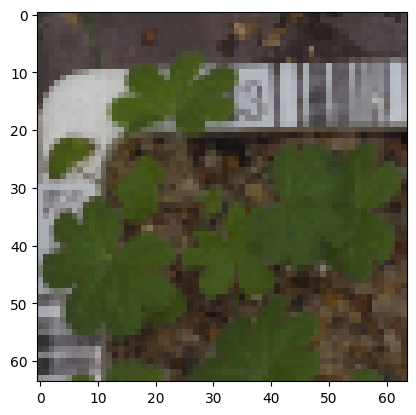

In [ ]:
images_decreased=[]
height = 64
width = 64
dimensions = (width, height)  
for i in range(len(images)):
  images_decreased.append( cv2.resize(images[i], dimensions, interpolation=cv2.INTER_LINEAR))
plt.imshow(images_decreased[3])

As we see, the image became more blurry than the same image with 128x128. However, this will also allow computer to spend less computational power.

#Data Pre-processing and Compatibility#

In this section, we will attempt to remove unwanted noise from the images by using Gaussian Blurring, apply the normalization, and split the data into train and test. Also, we will need to handle imbalance and ensure data compatibility.

##Gaussian Blur##

In [ ]:
# We apply Gaussian Blur to reduce the noise in an image that we resized

images_gb_reduced=[]
for i in range(len(images)):
  # gb[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
  images_gb_reduced.append(cv2.GaussianBlur(images_decreased[i], ksize =(3,3),sigmaX =  0))

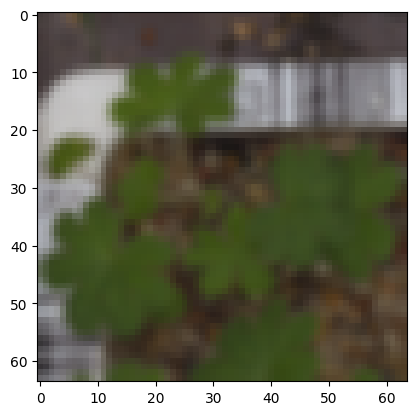

In [ ]:
plt.imshow(images_gb_reduced[3])

Applying the Gaussian blur on the image with reduced size and pixel resulted in a very blurry image. It may be difficult for CNN to recognize this image properly and detect its relevant features. Therefore, I will try to apply Gaussian blur on the original image which is 128x128

In [ ]:
images_gb=[]
for i in range(len(images)):
  # gb[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
  images_gb.append(cv2.GaussianBlur(images[i], ksize =(3,3),sigmaX =  0))

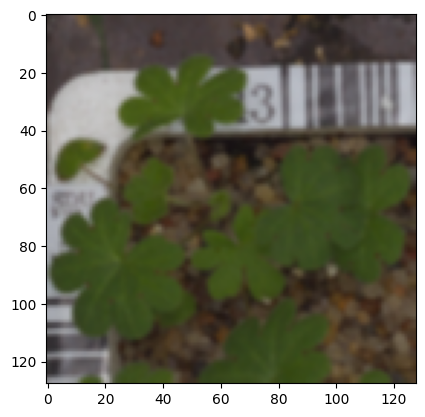

In [ ]:
plt.imshow(images_gb[3])

As we can see, the image above is more recognizable than the other. I will keep this.

##Splitting the Dataset##

In [ ]:
# We will first split the data into temp (train + validation) and test sets. We already imported the necessary function from the scikit package.

X_temp, X_test, y_temp, y_test = train_test_split(np.array(images_gb),labels , test_size=0.25, random_state=1, stratify=labels)

# Then, we will split the temp data into train and validation

X_train, X_val, y_train, y_val = train_test_split(X_temp,y_temp , test_size=0.25, random_state=1, stratify=y_temp)

In [ ]:
#Let's see the shape of each set

print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape,y_test.shape)

(2671, 128, 128, 3) (2671, 1)
(891, 128, 128, 3) (891, 1)
(1188, 128, 128, 3) (1188, 1)


##Reducing the Imbalance##

We will increase the weights of the minority classes to treat class imbalance in dataset.

In [ ]:
from sklearn.utils import class_weight

labelList = labels.Label.unique()
class_weights = class_weight.compute_class_weight(class_weight = "balanced",
                                                  classes = np.array(labelList),
                                                  y = y_train.values.reshape(-1)
                                                  )
class_weights = dict(zip(np.array(range(len(labelList))), class_weights))

In [ ]:
# Let's list the calculated class weights

class_weights

{0: 0.7977897252090801,
 1: 0.833645443196005,
 2: 1.712179487179487,
 3: 1.7806666666666666,
 4: 0.6489310009718173,
 5: 1.0117424242424242,
 6: 1.3825051759834368,
 7: 0.7675287356321839,
 8: 1.0257296466973886,
 9: 1.79502688172043,
 10: 1.5039414414414414,
 11: 0.6064940962761126}

As we can see, higher values have been assigned to classes with lower count (e.g., Class 2 and Class 3), whereas lower values have been assigned to classes with higher count (e.g., Class 4 and 11). The purpose is to give more weight to the ones that are seen less frequently, so the class imbalance can be reduced.

##Data Normalization##

Image pixel values in our dataset range from 0 to 255. In deep neural networks, it sometimes create exploding gradient problem. Normalization handles that issue by standardizing all the images to have their pixel values between 0-1. Also, it makes training faster and reduces the chance of being stuck at a local optima.

In [ ]:
X_train_normalized = X_train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0

##Encoding the Target Variable##

This is a classification problem with 12 classes in target variable. Therefore, we have to hot-encode our target variable.

In [ ]:
enc = LabelBinarizer()
y_train_encoded = enc.fit_transform(y_train)
y_val_encoded=enc.transform(y_val)
y_test_encoded=enc.transform(y_test)

##Checking the shape of the data##

We will check the shape of the data if it is compatible with Keras models where the input features are 4-dimensional for a Conv2D layer.

In [ ]:
y_train_encoded.shape

(2671, 12)

In [ ]:
y_val_encoded.shape

(891, 12)

In [ ]:
y_test_encoded.shape

(1188, 12)

In [ ]:
X_train_normalized.shape

(2671, 128, 128, 3)

In [ ]:
X_val_normalized.shape

(891, 128, 128, 3)

In [ ]:
X_test_normalized.shape

(1188, 128, 128, 3)

We do not need to reshape the data, because it seems that it is compatible with Keras models.

#CNN Model Building#

In [ ]:
# We will use the code below each time we run a new model to clear the previous model's history

from tensorflow.keras import backend
backend.clear_session()

In [ ]:
# Then, we will fix the seed again. This process must be repeated after a new model is run

import random
np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

##Model 1##

###Creating the Layers###

In [ ]:
# The function Sequential initiates a sequential model, meaning that the analysis will be done in a sequential manner

model_1 = Sequential() # We say model_1, because we may need to look at several models to find out the best one

# We add the first convolution layer with 64 filters and kernel size 3x3.
# Padding is 'same', so it provides the output size same as the input size.
# Input_shape refers to input image dimension of the images in our dataset. 128 pixels of width and height, and 3 colors (RGB).

model_1.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(128, 128, 3)))

# We add max pooling to reduce the size of output of the first convolution layer

model_1.add(MaxPooling2D((2, 2), padding = 'same'))

model_1.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model_1.add(MaxPooling2D((2, 2), padding = 'same'))
model_1.add(BatchNormalization())

model_1.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model_1.add(MaxPooling2D((2, 2), padding = 'same'))

# We flatten the output of the convolution layer after max pooling, so it is ready for creating dense connections
model_1.add(Flatten())

# We add a fully connected dense layer with 100 neurons 

model_1.add(Dense(100, activation='relu'))

# We the output layer with 12 neurons, because we have 12 classses
# We use softmax as activation function, because this is a multi-class classification problem  
model_1.add(Dense(12, activation='softmax'))

# We use Adam optimizer
opt = Adam()

# We compile the model
# We use categorical crossentropy, because the target variable is a multi-class category

model_1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Let's print the model summary

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                        

###Training the model using train data###

In [ ]:
history_1 = model_1.fit(
            X_train_normalized, y_train_encoded,
            epochs=40, # We will train the data in 50 epochs
            validation_data=(X_val_normalized,y_val_encoded), 
            batch_size=32, #We will train the data in batches of 32
            verbose=2 # This will show the number of epoch while running the analysis
)

Epoch 1/40
84/84 - 11s - loss: 1.9494 - accuracy: 0.3628 - val_loss: 2.3513 - val_accuracy: 0.1987 - 11s/epoch - 130ms/step
Epoch 2/40
84/84 - 2s - loss: 1.1341 - accuracy: 0.6129 - val_loss: 2.2783 - val_accuracy: 0.2873 - 2s/epoch - 26ms/step
Epoch 3/40
84/84 - 3s - loss: 0.8344 - accuracy: 0.7181 - val_loss: 2.0781 - val_accuracy: 0.2727 - 3s/epoch - 32ms/step
Epoch 4/40
84/84 - 2s - loss: 0.6382 - accuracy: 0.7814 - val_loss: 1.6368 - val_accuracy: 0.5365 - 2s/epoch - 28ms/step
Epoch 5/40
84/84 - 2s - loss: 0.5139 - accuracy: 0.8222 - val_loss: 1.2621 - val_accuracy: 0.6554 - 2s/epoch - 26ms/step
Epoch 6/40
84/84 - 2s - loss: 0.4131 - accuracy: 0.8626 - val_loss: 1.0171 - val_accuracy: 0.6723 - 2s/epoch - 29ms/step
Epoch 7/40
84/84 - 2s - loss: 0.2828 - accuracy: 0.9079 - val_loss: 1.1285 - val_accuracy: 0.6375 - 2s/epoch - 25ms/step
Epoch 8/40
84/84 - 2s - loss: 0.2079 - accuracy: 0.9326 - val_loss: 1.3336 - val_accuracy: 0.6532 - 2s/epoch - 21ms/step
Epoch 9/40
84/84 - 2s - loss:

###Plotting the model performance###

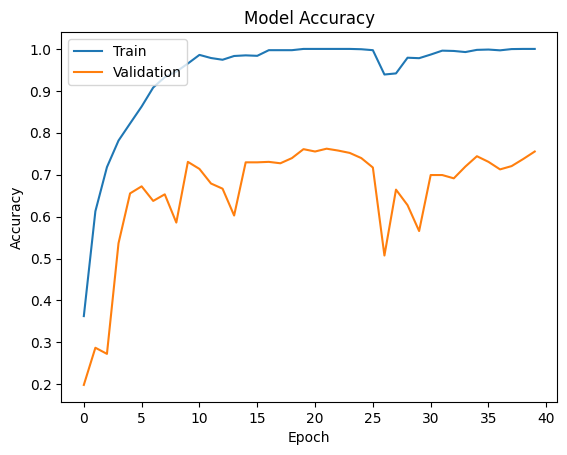

In [ ]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

We understand from the plot above that the train set of the model is extremely overfit, because the accuracy score of the train set is very high compared to the accuracy score of the validation set. It means that our train data does not only capture the real world data, but also captures much of the noise. 

###Evaluation of the model on test data###

In [ ]:
# Now, we will evaluate the model on test data

accuracy = model_1.evaluate(X_test_normalized, y_test_encoded, verbose=2)

38/38 - 0s - loss: 1.7031 - accuracy: 0.7559 - 461ms/epoch - 12ms/step


Training accuracy is 1, whereas test accuracy is 0.7726, showing that our model is extremely overfit and captures much of the noise, not representing the real world data well.

###Making Predictions###

In [ ]:
y_pred_test = model_1.predict(X_test_normalized)

# We need to convert probabilities to class labels, because confusion matrix require categorical data
y_pred_arg=np.argmax(y_pred_test,axis=1)

# We need to find the probability of the predicted class
y_pred_test_max = np.argmax(y_test_encoded,axis=1)


38/38 [==============================] - 0s 9ms/step


###Classification Report and Confusion Matrix###

              precision    recall  f1-score   support

           0       0.38      0.33      0.35        66
           1       0.85      0.86      0.85        97
           2       0.79      0.81      0.80        72
           3       0.87      0.88      0.87       153
           4       0.67      0.55      0.60        55
           5       0.81      0.70      0.75       119
           6       0.71      0.80      0.75       164
           7       0.84      0.75      0.79        55
           8       0.69      0.81      0.75       129
           9       0.66      0.53      0.59        58
          10       0.86      0.88      0.87       124
          11       0.73      0.74      0.74        96

    accuracy                           0.76      1188
   macro avg       0.74      0.72      0.73      1188
weighted avg       0.75      0.76      0.75      1188



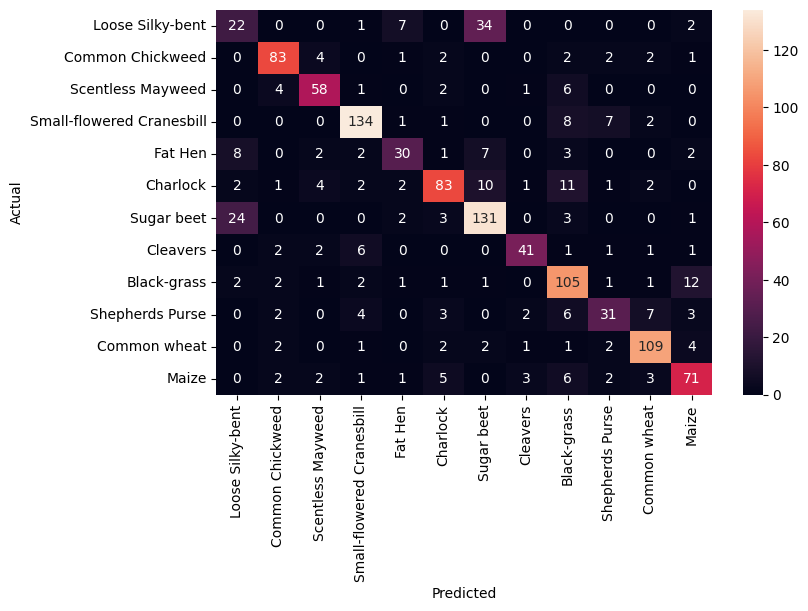

In [ ]:
print(classification_report(y_pred_test_max, y_pred_arg))

#We plot the heatmap using confusion matrix

cm = confusion_matrix(y_pred_test_max, y_pred_arg)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=labels_classes, yticklabels=labels_classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


We see that precision, recall, and f1 scores of most of the classes are not that high. The scores of class 0 is very low, showing that Loose Silky-bent has been misclassified mostly. Confusion matrix supports that as well. The model was confused it with Sugar beet most of the time. On the other hand, we see that Small-flowered Cranesbill, Sugar beet, Black-grass, and Common wheat were classified correctly most of the time, and they have relatively high precision, recall, and f1 scores. On the other hand, misclassification was common in Loose Silky-bent, Fat Hen, Cleavers, and Shepherds Purse. However, the overall accuracy of the test data is not good and dramatically differs from the accuracy score of the train data, revealing a huge overfitting issue. Therefore, we will try a second model with different parameters.

##Model 2 -- Adding more layers and hyperparameter tuning##

In [ ]:
from tensorflow.keras import backend
backend.clear_session()

In [ ]:
import random
np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

###Creating the Layers###

In [ ]:


model_2 = Sequential()

model_2.add(Conv2D(128, (3, 3), activation='relu', padding="same", input_shape=(128, 128, 3)))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D((2, 2), padding = 'same'))
model_2.add(Dropout(0.25))

model_2.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model_2.add(MaxPooling2D((2, 2), padding = 'same'))


model_2.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model_2.add(MaxPooling2D((2, 2), padding = 'same'))

model_2.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D((2, 2), padding = 'same'))

model_2.add(Flatten())

model_2.add(Dense(128, activation='relu',kernel_initializer='he_normal'))
model_2.add(Dense(64, activation='relu',kernel_initializer='he_normal'))
model_2.add(Dropout(0.25))
model_2.add(Dense(32, activation='relu',kernel_initializer='he_normal'))

# We the output layer with 12 neurons, because we have 12 classses
# We use softmax as activation function, because this is a multi-class classification problem  
model_2.add(Dense(12, activation='softmax'))

# We use Adam optimizer
adam = optimizers.Adam(learning_rate=1e-3)

# We compile the model
# We use categorical crossentropy, because the target variable is a multi-class category

model_2.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 128)     3584      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 128)    512       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0

###Training the Data on Train Set###

In [ ]:
history_2 = model_2.fit(
            X_train_normalized, y_train_encoded,
            epochs=30, # We will train the data in 30 epochs
            validation_data=(X_val_normalized,y_val_encoded), 
            batch_size=25, #We will train the data in batches of 32
            verbose=2 # This will show the number of epoch while running the analysis
)

Epoch 1/30
107/107 - 15s - loss: 2.3482 - accuracy: 0.2022 - val_loss: 4.4146 - val_accuracy: 0.1380 - 15s/epoch - 138ms/step
Epoch 2/30
107/107 - 7s - loss: 1.6214 - accuracy: 0.4695 - val_loss: 7.9609 - val_accuracy: 0.1380 - 7s/epoch - 68ms/step
Epoch 3/30
107/107 - 7s - loss: 1.1472 - accuracy: 0.6162 - val_loss: 6.9401 - val_accuracy: 0.1369 - 7s/epoch - 66ms/step
Epoch 4/30
107/107 - 7s - loss: 0.9701 - accuracy: 0.6750 - val_loss: 10.2075 - val_accuracy: 0.1380 - 7s/epoch - 64ms/step
Epoch 5/30
107/107 - 7s - loss: 0.7735 - accuracy: 0.7413 - val_loss: 2.9166 - val_accuracy: 0.2795 - 7s/epoch - 63ms/step
Epoch 6/30
107/107 - 7s - loss: 0.7097 - accuracy: 0.7634 - val_loss: 1.0315 - val_accuracy: 0.6532 - 7s/epoch - 64ms/step
Epoch 7/30
107/107 - 7s - loss: 0.5904 - accuracy: 0.7866 - val_loss: 2.5683 - val_accuracy: 0.4792 - 7s/epoch - 63ms/step
Epoch 8/30
107/107 - 7s - loss: 0.4987 - accuracy: 0.8270 - val_loss: 0.8683 - val_accuracy: 0.7250 - 7s/epoch - 63ms/step
Epoch 9/30
1

###Plotting the Model Performance###

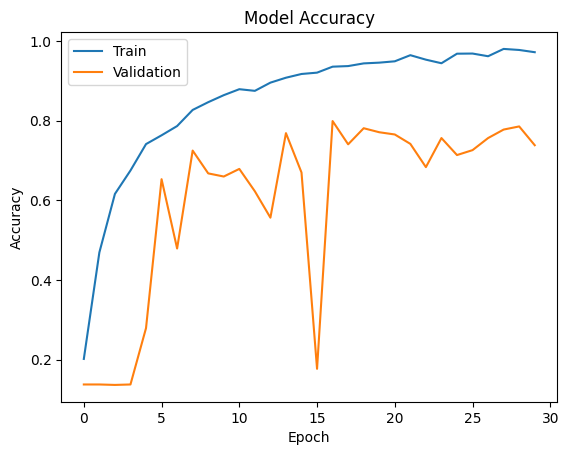

In [ ]:
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

The plot shows two main things. First, there is still a huge difference between train and validation sets in terms of accuracy score, indicating that our model is very overfit. Second, the changes in the accuracy score of validation set is very erratic, having drastic ups and downs. I don't know why it is like that.

###Evaluation of the model on test data###

In [ ]:
accuracy = model_2.evaluate(X_test_normalized, y_test_encoded, verbose=2)

38/38 - 1s - loss: 1.4178 - accuracy: 0.7500 - 1s/epoch - 30ms/step


Training accuracy is around .96, whereas test accuracy is 0.75, showing that our model is extremely overfit and captures much of the noise, not representing the real world data well.

###Making predictions###

In [ ]:
y_pred_test2 = model_2.predict(X_test_normalized)

# We need to convert probabilities to class labels, because confusion matrix require categorical data
y_pred_arg2=np.argmax(y_pred_test2,axis=1)

# We need to find the probability of the predicted class
y_pred_test_max2 = np.argmax(y_test_encoded,axis=1)

38/38 [==============================] - 1s 14ms/step


###Classification report and confusion matrix###

              precision    recall  f1-score   support

           0       0.62      0.30      0.41        66
           1       0.85      0.86      0.85        97
           2       0.69      0.89      0.78        72
           3       0.86      0.77      0.81       153
           4       0.64      0.76      0.69        55
           5       0.79      0.75      0.77       119
           6       0.81      0.74      0.78       164
           7       0.93      0.69      0.79        55
           8       0.62      0.85      0.72       129
           9       0.66      0.69      0.67        58
          10       0.74      0.94      0.83       124
          11       0.79      0.50      0.61        96

    accuracy                           0.75      1188
   macro avg       0.75      0.73      0.73      1188
weighted avg       0.76      0.75      0.74      1188



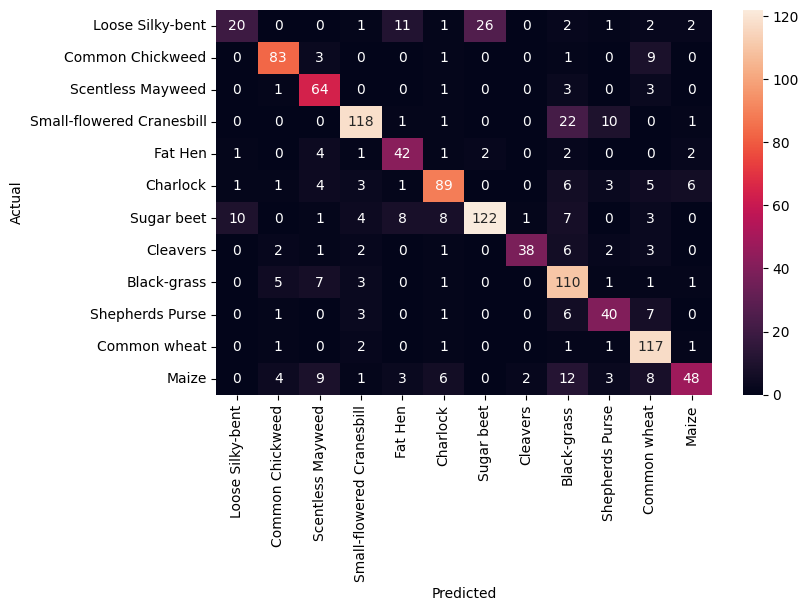

In [ ]:
print(classification_report(y_pred_test_max2, y_pred_arg2))

#We plot the heatmap using confusion matrix

cm = confusion_matrix(y_pred_test_max2, y_pred_arg2)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=labels_classes, yticklabels=labels_classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

It is very similar to the confusion matrix and classification report of the previous model. There are improvements though. For example, precision score of Class 0 got improved dramatically. Likewise, precision score of Class 7 is above .90 now. However, these are very individual and specific improvements, and some values got reduced as well. For example, the number of correctly classified images got reduced for small-flowered cranesbill. All of these are very individual and specific changes. Overall, there is still a huge difference between the accuracy scores of train and test data sets.

##Model 3 -- Data Augmentation##

Even though the Model 1 and Model 2 differed from each other in terms of layers and hyperparameters, the result was almost the same and there was no improvement of the overfitting problem. It may be due to the lack of a large number of images. Therefore, we will try to use data augmentation and create data in which original images will be changed translationally. By doing so, we will create data without changing the original images in a radical way, and we know that CNN is translation invariant, meaning that it can still recognize the translationally changed object. 

In [ ]:
from tensorflow.keras import backend
backend.clear_session()

import random
np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

###Data Augmentation Parameters###

In [ ]:
# I will use the parameters below to make translational changes in the images

train_dataug = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True,
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=20, 
                              shear_range = 0.1,
                              zoom_range=0.1)

###Creating the layers###

I will use the same layers as Model 2, but I will use data augmentation this time, so we will see if data augmentation had an impact.

In [ ]:
model_3 = Sequential()

model_3.add(Conv2D(128, (3, 3), activation='relu', padding="same", input_shape=(128, 128, 3)))
model_3.add(BatchNormalization())
model_3.add(MaxPooling2D((2, 2), padding = 'same'))
model_3.add(Dropout(0.25))

model_3.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model_3.add(MaxPooling2D((2, 2), padding = 'same'))


model_3.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model_3.add(MaxPooling2D((2, 2), padding = 'same'))

model_3.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model_3.add(BatchNormalization())
model_3.add(MaxPooling2D((2, 2), padding = 'same'))

model_3.add(Flatten())

model_3.add(Dense(128, activation='relu',kernel_initializer='he_normal'))
model_3.add(Dense(64, activation='relu',kernel_initializer='he_normal'))
model_3.add(Dropout(0.25))
model_3.add(Dense(32, activation='relu',kernel_initializer='he_normal'))

# We the output layer with 12 neurons, because we have 12 classses
# We use softmax as activation function, because this is a multi-class classification problem  
model_3.add(Dense(12, activation='softmax'))

# We use Adam optimizer
adam = optimizers.Adam(learning_rate=1e-3)

# We compile the model
# We use categorical crossentropy, because the target variable is a multi-class category

model_3.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

###Training the data on train set###

In [ ]:
history_3 = model_3.fit(train_dataug.flow(X_train_normalized,y_train_encoded,
                                       batch_size=25, 
                                       seed=1,
                                       shuffle=False),
                    epochs=30,
                    steps_per_epoch=X_train_normalized.shape[0] // 25,
                    validation_data=(X_val_normalized,y_val_encoded),
                    verbose=2)

Epoch 1/30
106/106 - 19s - loss: 2.2723 - accuracy: 0.2211 - val_loss: 2.3694 - val_accuracy: 0.2301 - 19s/epoch - 183ms/step
Epoch 2/30
106/106 - 13s - loss: 1.8611 - accuracy: 0.3515 - val_loss: 2.7027 - val_accuracy: 0.1964 - 13s/epoch - 125ms/step
Epoch 3/30
106/106 - 14s - loss: 1.6392 - accuracy: 0.4237 - val_loss: 12.8345 - val_accuracy: 0.1302 - 14s/epoch - 136ms/step
Epoch 4/30
106/106 - 13s - loss: 1.4313 - accuracy: 0.5057 - val_loss: 112.3025 - val_accuracy: 0.1291 - 13s/epoch - 124ms/step
Epoch 5/30
106/106 - 13s - loss: 1.3297 - accuracy: 0.5495 - val_loss: 271.1709 - val_accuracy: 0.1291 - 13s/epoch - 124ms/step
Epoch 6/30
106/106 - 14s - loss: 1.2735 - accuracy: 0.5548 - val_loss: 520.7610 - val_accuracy: 0.1291 - 14s/epoch - 134ms/step
Epoch 7/30
106/106 - 13s - loss: 1.1975 - accuracy: 0.5835 - val_loss: 425.6056 - val_accuracy: 0.1291 - 13s/epoch - 127ms/step
Epoch 8/30
106/106 - 14s - loss: 1.1883 - accuracy: 0.5922 - val_loss: 466.2570 - val_accuracy: 0.1302 - 14s/

###Plotting the Model Performance###

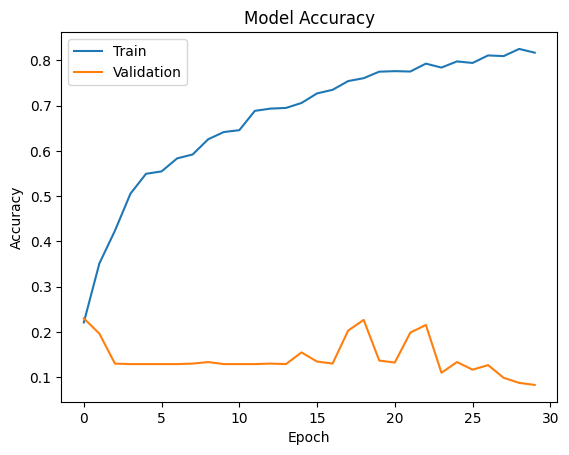

In [ ]:
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

This is the worst model I have ever seen, and I think there is even no need to explain why. 

###Evaluation of the Model on Test Data###

In [ ]:
accuracy = model_3.evaluate(X_test_normalized, y_test_encoded, verbose=2)

38/38 - 1s - loss: 630.7676 - accuracy: 0.0943 - 675ms/epoch - 18ms/step


The accuracy score of test data is ridiculously low.

###Making predictions###

In [ ]:
y_pred_test3 = model_3.predict(X_test_normalized)

# We need to convert probabilities to class labels, because confusion matrix require categorical data
y_pred_arg3=np.argmax(y_pred_test3,axis=1)

# We need to find the probability of the predicted class
y_pred_test_max3 = np.argmax(y_test_encoded,axis=1)

38/38 [==============================] - 1s 15ms/step


###Classification report and confusion matrix###

              precision    recall  f1-score   support

           0       1.00      0.02      0.03        66
           1       0.00      0.00      0.00        97
           2       0.00      0.00      0.00        72
           3       0.00      0.00      0.00       153
           4       0.00      0.00      0.00        55
           5       0.00      0.00      0.00       119
           6       0.00      0.00      0.00       164
           7       0.00      0.00      0.00        55
           8       0.00      0.00      0.00       129
           9       0.00      0.00      0.00        58
          10       0.35      0.13      0.19       124
          11       0.08      0.99      0.15        96

    accuracy                           0.09      1188
   macro avg       0.12      0.09      0.03      1188
weighted avg       0.10      0.09      0.03      1188



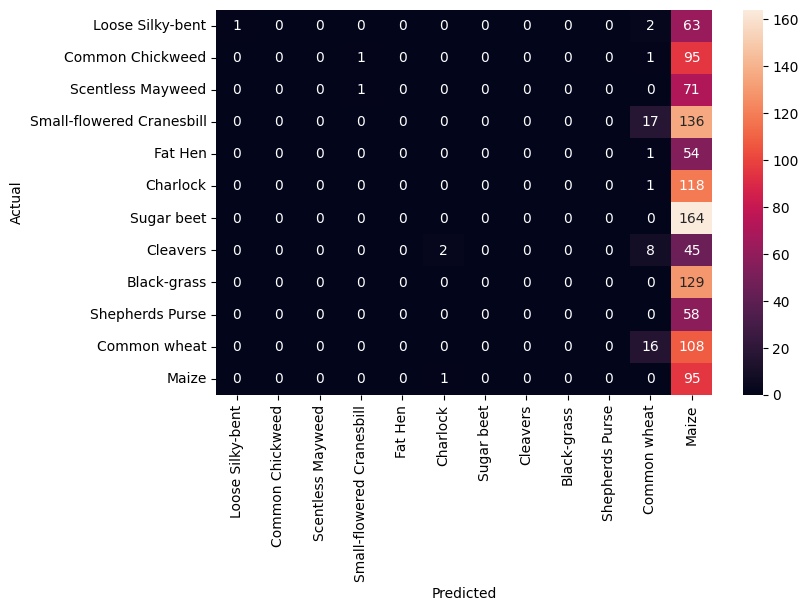

In [ ]:
print(classification_report(y_pred_test_max3, y_pred_arg3))

#We plot the heatmap using confusion matrix

cm = confusion_matrix(y_pred_test_max3, y_pred_arg3)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=labels_classes, yticklabels=labels_classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

It is completely horrific. Nearly all images were misclassified. Accuracy of the test data is all over the place. 

##Model 4 -- Data Augmentation with a Simpler Model###

Perhaps, data augmentation with a complex model with a lot of layers and hyperparameters was not a good idea. Data augmentation may work with simpler models better. I will check if this is correct by using data augmentation with a similar version of my first model which was simpler than model 2.

In [ ]:
from tensorflow.keras import backend
backend.clear_session()

import random
np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

In [ ]:
# I will keep this simple as well
train_dataug2 = ImageDataGenerator(rotation_range=30, 
                                   )

###Creating the layers###

In [ ]:
model_4 = Sequential()

model_4.add(Conv2D(128, (3, 3), activation='relu', padding="same", input_shape=(128, 128, 3)))



model_4.add(MaxPooling2D((2, 2), padding = 'same'))

model_4.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model_4.add(MaxPooling2D((2, 2), padding = 'same'))
model_4.add(Conv2D(32, (3, 3), activation='relu', padding="same"))

model_4.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model_4.add(MaxPooling2D((2, 2), padding = 'same'))

model_4.add(Flatten())


model_4.add(Dense(100, activation='relu'))

 
model_4.add(Dense(12, activation='softmax'))


opt = Adam()

model_4.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

###Training the data on train set###

In [ ]:
history_4 = model_4.fit(train_dataug2.flow(X_train_normalized,y_train_encoded,
                                       batch_size=50, 
                                       seed=1,
                                       shuffle=False),
                    epochs=20,
                    validation_data=(X_val_normalized,y_val_encoded),
                    verbose=2)

Epoch 1/20
54/54 - 14s - loss: 2.4401 - accuracy: 0.1250 - val_loss: 2.4223 - val_accuracy: 0.1380 - 14s/epoch - 261ms/step
Epoch 2/20
54/54 - 11s - loss: 2.3714 - accuracy: 0.1696 - val_loss: 2.1148 - val_accuracy: 0.2727 - 11s/epoch - 208ms/step
Epoch 3/20
54/54 - 12s - loss: 1.7933 - accuracy: 0.3999 - val_loss: 1.6946 - val_accuracy: 0.4332 - 12s/epoch - 214ms/step
Epoch 4/20
54/54 - 10s - loss: 1.4124 - accuracy: 0.5095 - val_loss: 1.3744 - val_accuracy: 0.5028 - 10s/epoch - 187ms/step
Epoch 5/20
54/54 - 11s - loss: 1.1939 - accuracy: 0.5942 - val_loss: 1.2323 - val_accuracy: 0.5769 - 11s/epoch - 205ms/step
Epoch 6/20
54/54 - 11s - loss: 1.1219 - accuracy: 0.6241 - val_loss: 1.2000 - val_accuracy: 0.6162 - 11s/epoch - 208ms/step
Epoch 7/20
54/54 - 11s - loss: 0.9695 - accuracy: 0.6732 - val_loss: 1.1058 - val_accuracy: 0.6117 - 11s/epoch - 210ms/step
Epoch 8/20
54/54 - 11s - loss: 0.8744 - accuracy: 0.6986 - val_loss: 1.0364 - val_accuracy: 0.6532 - 11s/epoch - 195ms/step
Epoch 9/

###Plotting the model performance###

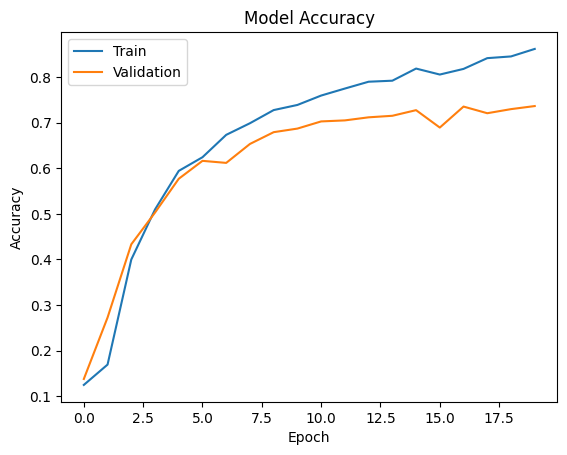

In [ ]:
plt.plot(history_4.history['accuracy'])
plt.plot(history_4.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Although accuracy scores of train set and validation set are not very high, this model is way better than the previous ones, mainly because the accuracy score of train set is closer to that of validation set compared how it was in previous models. It means way less overfitting and better representation of the real world data.

###Evaluation of the model on test data###

In [ ]:
accuracy = model_4.evaluate(X_test_normalized, y_test_encoded, verbose=2)

38/38 - 1s - loss: 0.8809 - accuracy: 0.7483 - 875ms/epoch - 23ms/step


###Making predictions###

In [ ]:
y_pred_test4 = model_4.predict(X_test_normalized)

# We need to convert probabilities to class labels, because confusion matrix require categorical data
y_pred_arg4=np.argmax(y_pred_test4,axis=1)

# We need to find the probability of the predicted class
y_pred_test_max4 = np.argmax(y_test_encoded,axis=1)

38/38 [==============================] - 1s 18ms/step


###Classification report and confusion matrix###

              precision    recall  f1-score   support

           0       0.52      0.20      0.29        66
           1       0.90      0.68      0.78        97
           2       0.70      0.81      0.75        72
           3       0.91      0.90      0.90       153
           4       0.66      0.35      0.45        55
           5       0.75      0.79      0.77       119
           6       0.62      0.91      0.73       164
           7       0.69      0.62      0.65        55
           8       0.79      0.71      0.75       129
           9       0.72      0.79      0.75        58
          10       0.85      0.90      0.88       124
          11       0.70      0.72      0.71        96

    accuracy                           0.75      1188
   macro avg       0.73      0.70      0.70      1188
weighted avg       0.75      0.75      0.74      1188



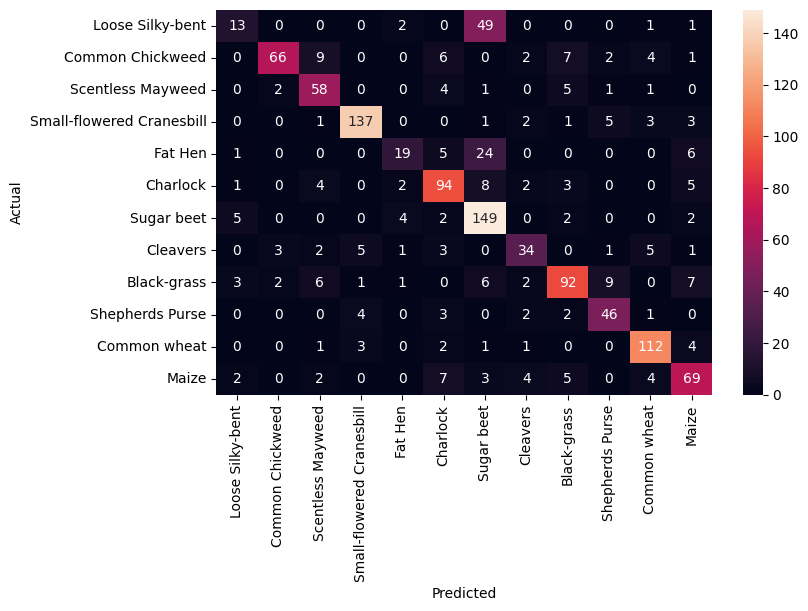

In [ ]:
print(classification_report(y_pred_test_max4, y_pred_arg4))

#We plot the heatmap using confusion matrix

cm = confusion_matrix(y_pred_test_max4, y_pred_arg4)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=labels_classes, yticklabels=labels_classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Again, class 0 was highly misclassified and confused with Sugar beet. However, overall, the precision, recall, and f1 scores of most classes got improved compared to previous models. For example, class 1 and class 4 has a precision score above .90, and 3 classes have a a recall score above .90, which was not the case in previous models. On the other hand, average accuracy is still around 0.75, a similar result with other models.

###Visualizing the Images based on Model 4###

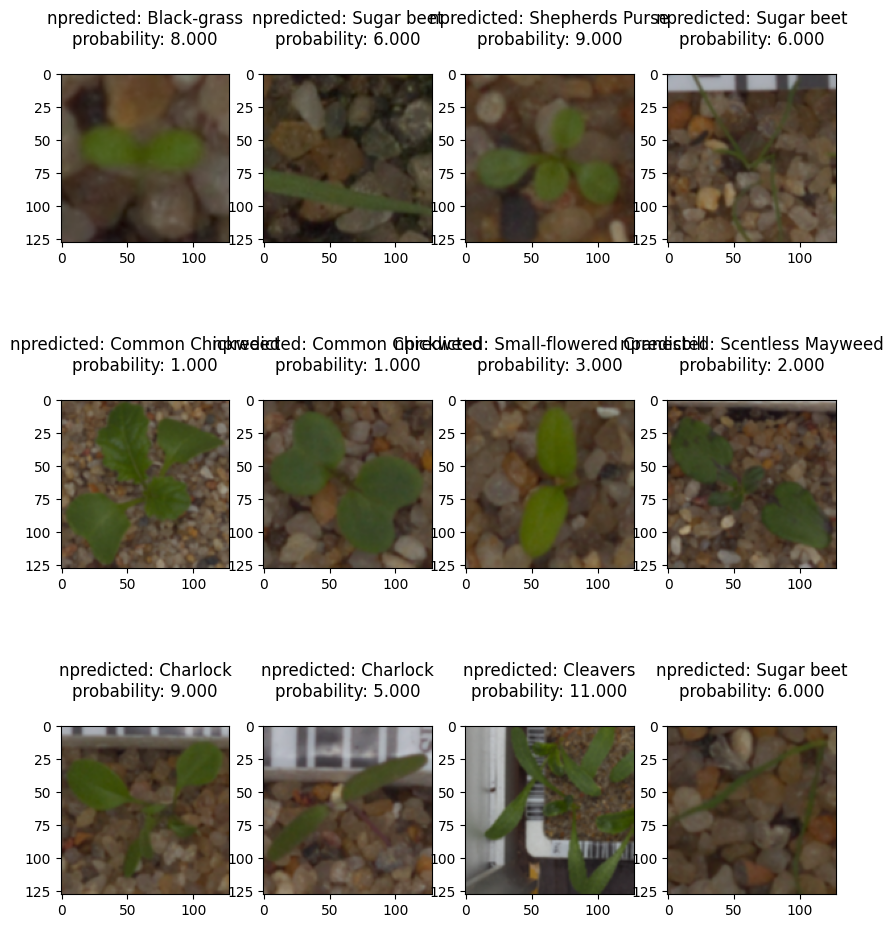

In [ ]:
rows = 3
cols = 4
fig = plt.figure(figsize=(10, 12))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.imshow(X_test[random_index, :])
        pred_label = labels_classes[y_pred_arg4[random_index]]
        pred_proba = y_pred_test_max4[random_index]
        ax.set_title("npredicted: {}\nprobability: {:.3f}\n".format(
            pred_label, pred_proba
        ))
plt.show()

#Final Conclusion and Key Takeaways#

I will go with Model 4, because it obviously has a less overfitting issue compared to Model 1, 2, and 3. Althoug Model 3 included data augmentation, it was the worst model. I don't know the exact reason, but it might be due to that the model was too complicated, having a lot of layers and parameters in both CNN and data augmentation sections. When I simplified them in Model 4, it resulted in a way better model with still similar accuracy, but less overfitting. I should say that Model 4 was not my first model after Model 3. I tweaked a lot and tuned hyperparameters in different ways, so I created a lot of other models that I had not included in this project. Model 4 was the final model after many tweaks and tuning. I think overfitting issue can be reduced further, but I am not sure if we can increase the accuracy, because whatever I tried, the overall accuracy of the test data was similar (around 0.75).

Another key takeaway was about the images. In all of the models, there was a high amount of misclassification for Loose Silky-bent, Fat hen, Cleavers, and Shepherds Purse. It may be because detecting their relevant features like edges is more difficult, because of their shape, image quality etc. Especially Loose Silky-bent was mostly confused with Sugar beet, maybe because Sugar beet looks like loose silky-bent. I don't know what the solution might be, but maybe Gaussian blur made images of plants so blurry that detecting features became difficult. These are plants that are very similar to each other in terms of shape and color, so higher-quality images may be required. 